In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # only for convenience
from analysis import *

# Load and prepare data

In [2]:
# Load data
X_es = []
spikes = []
for i in range(40, 40 + seeds_num):
    data_cues = load_data("./data/seqlearn_cues_v4_seed{}.pickle".format(i))
    X_es.append(data_cues["X_e"])
    spikes.append(data_cues["spikes"])

In [3]:
# Helper functions to get cross correlation
def get_crosscorr_phase(X_es, spikes, start_time):
    cc_array = np.zeros((seeds_num, clu_num, clu_num, cc_bins))
    for i in tqdm(range(seeds_num)):
        clu_neurs = get_cluster_neurons(X_es[i])
        spikes_dic = spikes[i]
        for clu_a in range(clu_num):
            for clu_b in range(clu_a, clu_num):
                spikes_a = get_spikes(clu_neurs[clu_a], spikes_dic, start_time)
                spikes_b = get_spikes(clu_neurs[clu_b], spikes_dic, start_time)
                cc_array[i, clu_a, clu_b] = cc_clu(spikes_a, spikes_b)
    return cc_array

def get_crosscorr(X_es, spikes):
    prelearn_time = growth_time + test_time + 2*relax_time + learn_time
    cc_array_bf = get_crosscorr_phase(X_es, spikes, growth_time)
    cc_array_af = get_crosscorr_phase(X_es, spikes, prelearn_time)

    cc_delta = np.zeros((seeds_num, 2, clu_num, cc_bins))
    for i in range(seeds_num):
        for clu_diff in range(clu_num):
            for clu_a in range(clu_num-clu_diff):
                cc_delta[i, 0, clu_diff] += cc_array_bf[i, clu_a, clu_a+clu_diff]
                cc_delta[i, 1, clu_diff] += cc_array_af[i, clu_a, clu_a+clu_diff]
                
    cc_norm = np.mean(cc_delta, 0)
    cc_diff = cc_norm[1] - cc_norm[0]
    cc_norm = ((cc_norm-cc_norm.min(axis=2)[:, :, None]) / 
        (cc_norm.max(axis=2)[:, :, None]-cc_norm.min(axis=2)[:, :, None]))
    cc_diff = ((cc_diff-cc_diff.min(axis=1)[:, None]) / 
        (cc_diff.max(axis=1)[:, None]-cc_diff.min(axis=1)[:, None]))
    
    return cc_norm, cc_diff

In [4]:
# Get cross correlations
cc_norm, cc_diff = get_crosscorr(X_es, spikes)

# Figure 

## Panel A

In [5]:
# Helper function to plot spike trains
def plot_spikes(ax, spikes_dic, neurs, t_start, xlabel=None, ylabel=None):
    neurs = np.concatenate(neurs)
    for i, neur in enumerate(neurs):
        times = spikes_dic[neur]
        ax.plot((times - t_start)/ms, i*np.ones_like(times), '.', c='C0', ms=4)
    ax.set_ylim(0, len(neurs))
    ax.set_xlim(0, 5_00)
    ax.set_xticks([0, 250, 500])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

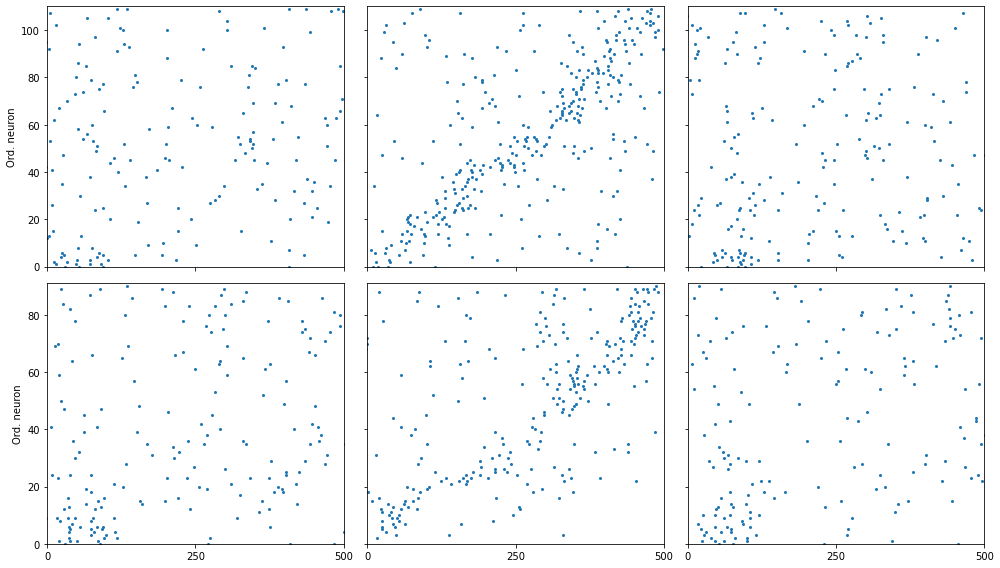

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharey='row', sharex=True)

t_start = growth_time + offset_time
t_1 = t_start + test_time/2
t_2 = t_start + test_time + relax_time + learn_time/20
t_3 = t_start + test_time + relax_time + learn_time + relax_time + test_time/2
t_len = 0.5 * second

# Top row
spikes_e = spikes[0]
clu_neurs = get_cluster_neurons(X_es[0])
plot_spikes(axs[0, 0], spikes_e, clu_neurs, t_1, ylabel="Ord. neuron")
plot_spikes(axs[0, 1], spikes_e, clu_neurs, t_2)
plot_spikes(axs[0, 2], spikes_e, clu_neurs, t_3)

# Bottom row
spikes_e = spikes[1]
clu_neurs = get_cluster_neurons(X_es[1])
plot_spikes(axs[1, 0], spikes_e, clu_neurs, t_1, ylabel="Ord. neuron")
plot_spikes(axs[1, 1], spikes_e, clu_neurs, t_2)
plot_spikes(axs[1, 2], spikes_e, clu_neurs, t_3)

fig.tight_layout()
plt.show()

## Panel B

In [7]:
# Helper function to plot cross-correlations
def plot_cc(ax, cc):
    im = ax.imshow(cc[1:], origin="lower", cmap = plt.get_cmap("jet"), vmin=0, vmax=1)
    ax.set_yticks([0, 2, 4, 6])
    ax.set_yticklabels([1, 3, 5, 7])
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_xticklabels([-50, -25, 0, 25, 50])
    plt.colorbar(im, ax=ax)

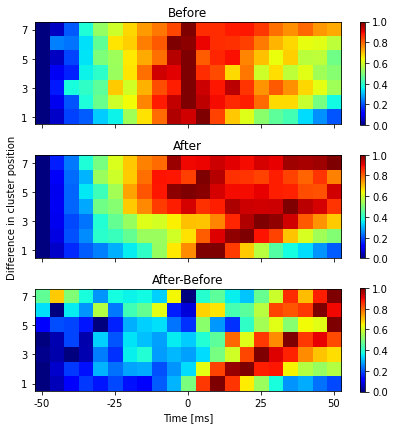

In [8]:
fig, axs = plt.subplots(3, figsize=(6, 6), sharex=True)

# Top
plot_cc(axs[0], cc_norm[0])
axs[0].set_title("Before")

# Middle
plot_cc(axs[1], cc_norm[1])
axs[1].set_title("After")
axs[1].set_ylabel("Difference in cluster position")

# Bottom
plot_cc(axs[2], cc_diff)
axs[2].set_title("After-Before")
axs[2].set_xlabel("Time [ms]")

fig.tight_layout()
plt.show()